In [1]:
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
import pandas as pd
import pickle 
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

# load the DataFrame from a pickle file
df = pd.read_pickle('dataset/processed.pkl')
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-01-01'
TRADE_START_DATE = '2021-01-02'
TRADE_END_DATE = '2023-03-26'

In [2]:
INDICATORS = ['macd','rsi_14', 'rsi_21','rsi_28',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [3]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env

from gymnasium.wrappers import EnvCompatibility

In [4]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

80301
16211


In [5]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 378


In [31]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [32]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

In [33]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

In [34]:
from ray.rllib.agents import ppo
ray.shutdown()

In [35]:
use_ddppo = False
config = ppo.PPOConfig() 

In [36]:
# registering the environment to ray
register_env("finrl_trading", env_creator_trading)
# define trainer
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl_trading', config=config)
else:
    trainer = ppo.PPOTrainer(env='finrl_trading', config=config)
    

2023-03-29 17:25:15,751	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
2023-03-29 17:25:18,990	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(RolloutWorker pid=31783) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=31783)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=31776) 2023-03-29 17:25:25,312	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=31776) 2023-03-29 17:25:25,312	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are n

In [37]:
# load saved agent
#cwd_checkpoint = f"results/checkpoints/ppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
#print(f"Restoring from checkpoint {total_episodes+1}")
cwd_checkpoint = 'results/checkpoints/ppo_101/checkpoint_000106'
trainer.restore(cwd_checkpoint)

2023-03-29 17:25:27,298	INFO trainable.py:791 -- Restored on 172.24.64.119 from checkpoint: results/checkpoints/ppo_101/checkpoint_000106
2023-03-29 17:25:27,299	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 106, '_timesteps_total': None, '_time_total': 1021.3191854953766, '_episodes_total': 152}


In [38]:
import time 
def DRL_prediction(model, environment):
    start = time.time()
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            break
    print("Test Finished!")
    print((time.time()-start),'s')
    return account_memory, actions_memory

In [39]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)

Test Finished!
2.142585515975952 s


In [40]:
df_account_value.tail()

,date,account_value
554,2023-03-17,975418.030817
555,2023-03-20,987337.330008
556,2023-03-21,997348.096330
557,2023-03-22,981948.217692
558,2023-03-23,982010.573072


In [41]:
df_actions.tail(100)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2022-10-27,0,-62,-100,0,0,100,1,0,4,0,...,-24,0,-69,-10,-14,93,0,-100,-5,100
2022-10-28,0,-26,-61,0,58,79,-19,0,100,0,...,-8,25,100,100,68,-93,0,-53,0,77
2022-10-31,0,0,0,100,0,0,100,0,0,0,...,0,-100,-17,-19,-83,0,0,-47,2,100
2022-11-01,69,0,100,-24,-58,0,-29,0,0,0,...,0,-23,-100,-92,0,18,0,100,-2,87
2022-11-02,100,0,-59,-35,0,100,-71,0,-63,0,...,0,100,-54,-60,0,-18,0,-59,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16,-11,0,100,100,-100,-100,0,96,72,0,...,0,0,-2,-27,-56,-70,100,100,-8,1
2023-03-17,-70,0,100,0,0,-64,0,0,100,0,...,0,0,0,-16,96,-6,0,0,0,0
2023-03-20,-13,0,0,0,-5,0,0,-25,-100,0,...,0,100,0,0,1,35,-61,-13,0,-1


In [46]:
df_actions.sum()

AAPL       0
AMGN       0
AXP     1222
BA         0
CAT        0
CRM        0
CSCO       0
CVX       71
DIS        0
GS         0
HD       101
HON       89
IBM      200
INTC       0
JNJ     3142
JPM        0
KO       100
MCD      100
MMM       72
MRK        0
MSFT     200
NKE      100
PG        60
TRV        0
UNH      226
V          0
VZ       122
WBA        2
WMT        0
dtype: int64

In [42]:
df_actions.to_csv('actions.csv', index=False)

In [43]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.008150
Cumulative returns    -0.017989
Annual volatility      0.162375
Sharpe ratio           0.030634
Calmar ratio          -0.044177
Stability              0.037989
Max drawdown          -0.184491
Omega ratio            1.005139
Sortino ratio          0.042701
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.893813
Daily value at risk   -0.020438
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [44]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (558, 8)
Annual return          0.026560
Cumulative returns     0.059761
Annual volatility      0.163547
Sharpe ratio           0.242307
Calmar ratio           0.121052
Stability              0.037858
Max drawdown          -0.219408
Omega ratio            1.041677
Sortino ratio          0.339596
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933170
Daily value at risk   -0.020448
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (558, 8)


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2021-01-04
End date,2023-03-23
Total months,26
,Backtest
Annual return,-0.815%
Cumulative returns,-1.799%
Annual volatility,16.238%
Sharpe ratio,0.03
Calmar ratio,-0.04
Stability,0.04
Max drawdown,-18.449%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.45,2022-04-20,2022-09-30,NaT,NaN
1,9.21,2022-02-09,2022-03-08,2022-04-20,51
2,7.29,2021-11-12,2021-12-01,2021-12-16,25
3,6.13,2022-01-07,2022-01-24,2022-02-09,24
4,4.39,2021-08-27,2021-09-30,2021-11-08,52


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'ob

Stress Events,mean,min,max
New Normal,0.00%,-3.38%,3.96%


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


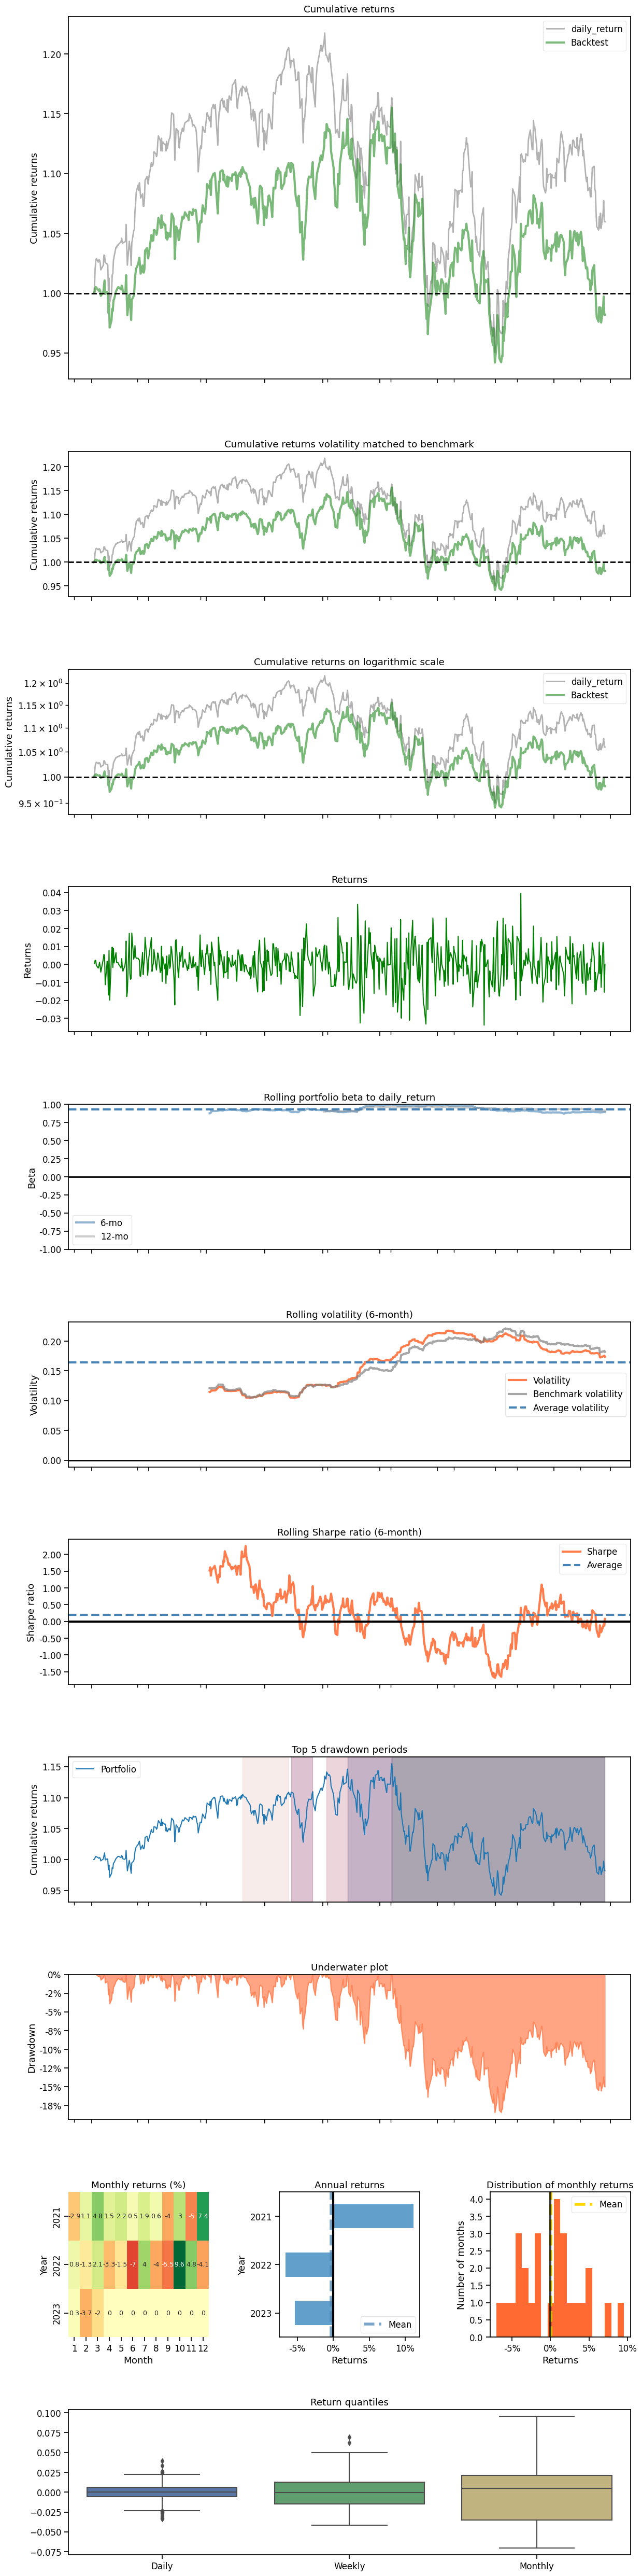

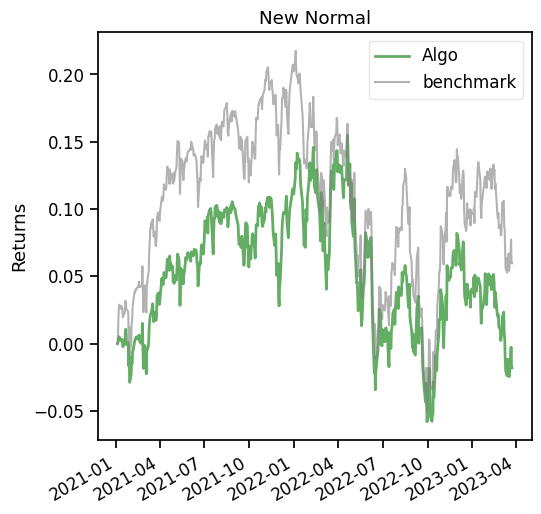

In [45]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])